#Tokenize and Embed



In [ ]:
import tensorflow as tf
import numpy as np
sentence = [ "The keys that I left on the kitchen table yesterday are missing"]

vectorizer = tf.keras.layers.TextVectorization( # layer in TensorFlow is used to convert text (like words or sentences) into numerical representations
    output_mode="int", #This specifies that the layer should output integer indices for each token (word or punctuation).
                                              #Each unique token in your vocabulary gets assigned a unique integer ID.
    output_sequence_length=12 # This parameter determines the fixed length of the output sequences.
                                                #if you set output_sequence_length=None (or omit it),
                                                #the layer will output sequences of varying lengths, corresponding to the original length of each input sentence.
)

vectorizer.adapt(sentence)

token_ids = vectorizer(sentence)
print("Token IDs:", token_ids.numpy())

Token IDs: [[ 2 10  4 11  8  6  2  9  5  3 12  7]]


#Create Embedding


In [ ]:
vocab_size = len(vectorizer.get_vocabulary())

embed_dim = 16

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embed_dim
)

X = embedding(token_ids)
print("Embeddings shape:", X.shape)#(batch size, output_seq_length, embedd_dim)


Embeddings shape: (1, 12, 16)


In [ ]:
X[0][0] #Embedding vector for the first token same as X[0,0]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 0.01357459, -0.00976106,  0.00396129, -0.04503888, -0.02171625,
       -0.03621303,  0.04430345,  0.04958124,  0.0241599 , -0.03810234,
        0.00199459,  0.04641083,  0.01564396, -0.03089219, -0.01779247,
       -0.03980274], dtype=float32)>

In [ ]:
#Removing batch dimension to reduce complexity
X = X[0] #X[0] accesses the first (and only) item in that batch

X.shape


TensorShape([12, 16])

# Compute similarity scores (dot product)(attention Scores)

In [ ]:
scores = tf.matmul(X,X, transpose_b=True) # (12, 16) @ (16, 12)
#transpose_b=True explicitly tells tf.matmul to transpose the second matrix (B) before performing the multiplication
print("Attention Scores",scores)
print(scores.shape)


Attention Scores tf.Tensor(
[[ 1.58211384e-02 -1.15578785e-03 -5.73228579e-03 -1.08657656e-02
   1.30487978e-03  4.17782646e-03  1.58211384e-02  9.99935204e-04
   1.66462408e-03  7.09979213e-04  3.99213051e-04  7.53648637e-05]
 [-1.15578785e-03  1.14874030e-02 -3.75133497e-03  1.42757501e-03
   6.64704712e-03  1.59198104e-03 -1.15578785e-03  5.96320489e-03
  -1.75817905e-03 -2.70341337e-03 -2.94491998e-03 -3.72978603e-03]
 [-5.73228579e-03 -3.75133497e-03  1.58853587e-02  9.74130584e-04
  -4.54785815e-03  1.30550168e-03 -5.73228579e-03  1.08801387e-03
   2.69159791e-03  1.30926468e-03  4.37431037e-03  4.85906610e-03]
 [-1.08657656e-02  1.42757501e-03  9.74130584e-04  1.74994394e-02
   1.85645287e-04 -1.00851967e-03 -1.08657656e-02 -1.28852460e-03
  -1.04650346e-04 -2.92335940e-03 -3.12844431e-03 -2.39578518e-03]
 [ 1.30487978e-03  6.64704712e-03 -4.54785815e-03  1.85645287e-04
   1.89646538e-02  6.74826885e-03  1.30487978e-03  1.19714029e-02
   1.09014055e-03 -5.20450389e-03 -3.1969946

#Calulate attention weights

Also normalize with softmax function

In [ ]:
type(scores)

tensorflow.python.framework.ops.EagerTensor

#Tensor Concepts
A tensor is a generalization of scalars (0-rank tensor), vectors (1-rank tensor), and matrices (2-rank tensor) to an arbitrary number of dimensions (or ranks). For example:\
1. A single number (e.g., 5) is a 0-rank tensor (a scalar).
2. A list of numbers (e.g., [1, 2, 3]) is a 1-rank tensor (a vector).
3. A 2D array of numbers (like your scores with shape (12, 12)) is a 2-rank tensor (a matrix).
4. A 3D array (like X before slicing, shape (1, 12, 16)) is a 3-rank tensor. So, scores is a tensor, and more specifically, it's a matrix.

In [ ]:
attention_weights = tf.nn.softmax(scores, axis=-1)# axis specifies the dimension along which the softmax function should be applied.
                                                                                            #axis=0 → operates down columns (vertically)
                                                                                            #axis=1 or axis=-1 → operates across rows (horizontally)
                                                                                            # Effect: Softmax is applied independently to each row

print("Attention weights shape:", attention_weights.shape)


Attention weights shape: (12, 12)


#Why axis = -1 instead axis = 1
axis = -1 indicate the last dimension of the input tensor typically represents the "feature" or "element" dimension - the dimension you want to operate over.
#For Different Tensor Shapes:
**2D Tensor (Matrix):**

tensor.shape = (rows, columns)

Example: (10, 512)

 10 rows (sequences/samples)

 512 columns (features) ← last dimension

**3D Tensor:**

 tensor.shape = (batch_size, sequence_length, embedding_dim)

** 4D Tensor(Multi-head Attention)**

 tensor.shape = (batch, num_heads, seq_len, seq_len)

 Last dimension = key positions

 When you do softmax(scores, axis=-1), you're saying:
"For each position in all other dimensions, apply softmax across the last dimension"


#Practical Rule of Thumb
Last dimension = the "content" or "elements" you're working with

In embeddings: the feature values
In attention scores: the keys you're choosing from
In images: the color channels (RGB)
In time series: the feature measurements


In [ ]:
print(attention_weights.shape,X.shape)

print("\n",sum(attention_weights[0]))

(12, 12) (12, 16)

 tf.Tensor(1.0, shape=(), dtype=float32)


#Now calculate Weighted sum of embeddings(Outputs/context vectors)
Each word now context will be context aware

In [ ]:
context_vectors = tf.matmul(attention_weights, X) # Must maintain the order of matrix multiplication

print(context_vectors.shape)

(12, 16)


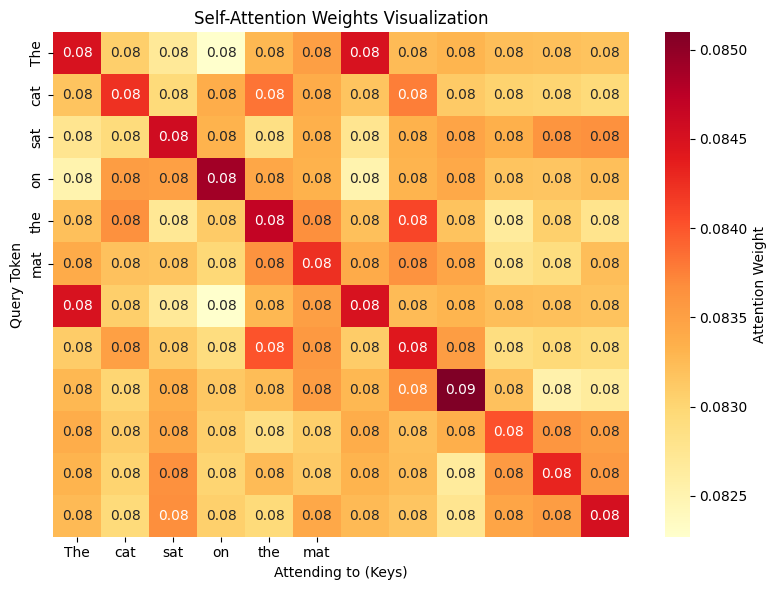

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your sentence
sentence = "The cat sat on the mat"
tokens = sentence.split()

# Your attention_weights (assuming you have this)
# Shape: (num_tokens, num_tokens)

# Visualize as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(attention_weights,
            annot=True,  # Show numbers
            fmt='.2f',   # 2 decimal places
            xticklabels=tokens,
            yticklabels=tokens,
            cmap='YlOrRd',
            cbar_kws={'label': 'Attention Weight'})
plt.title('Self-Attention Weights Visualization')
plt.xlabel('Attending to (Keys)')
plt.ylabel('Query Token')
plt.tight_layout()
plt.show()

#Class-Based approach(recommended)

In [8]:
import tensorflow as tf
import numpy as np

class SimplifiedSelfAttention:
  def __init__(self, embed_dim, output_sequence_length):
    #Initializes the SimplifiedSelfAttention class.
    self.embed_dim = embed_dim
    self.output_sequence_length = output_sequence_length
    self.vectorizer = None
    self.embedding = None


  def build_vectorizer(self,  sentence):

    self.vectorizer = tf.keras.layers.TextVectorization(
            output_mode="int",
            output_sequence_length=self.output_sequence_length
        )

    return self.vectorizer.adapt(sentence)


  def build_embedding(self):

    if self.vectorizer is None:
      raise ValueError("Vectorizer must be built before building embedding.")

    vocab_size = len(self.vectorizer.get_vocabulary())

    self.embedding = tf.keras.layers.Embedding(
        input_dim = vocab_size,
        output_dim = self.embed_dim
    )

  def calculate_attention(self, X):

    if self.embedding is None:
      raise ValueError("Embedding must be built before getting attention scores.")

    attention_scores = tf.matmul(X, X, transpose_b=True)

    attention_weights = tf.nn.softmax(attention_scores, axis = -1)

    context_vectors = tf.matmul(attention_weights,X)

    return attention_weights, context_vectors

  def forward(self, sentence):
    #Performs the full forward pass: tokenization, embedding, and   attention.

    if self.vectorizer is None:
      self.build_vectorizer(sentence)

    if self.embedding is None:
      self.build_embedding()

    token_ids = self.vectorizer(sentence)

    embeddings = self.embedding(token_ids)

    attention_weights, context_vectors = self.calculate_attention  (embeddings)

    return attention_weights, context_vectors, token_ids



if __name__=="__main__":

  sentence = ["The keys that I left on the kitchen table yesterday are missing"]
  model = SimplifiedSelfAttention(embed_dim=16, output_sequence_length=12)

  context_vectors, attention_weights, token_ids = model.forward(sentence)


In [14]:
print(context_vectors[0,0],token_ids.shape)

tf.Tensor(
[0.0840582  0.08340839 0.08275214 0.08301699 0.08319435 0.08302689
 0.0840582  0.08317641 0.08352574 0.08315963 0.08333989 0.08328317], shape=(12,), dtype=float32) (1, 12)


In [16]:
sum([0.0840582, 0.08340839, 0.08275214, 0.08301699, 0.08319435, 0.08302689,
 0.0840582,  0.08317641, 0.08352574, 0.08315963, 0.08333989, 0.08328317])

1.0